<a href="https://colab.research.google.com/github/noelfischer/ai_praktika/blob/main/5/P05b_FashionMNIST_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ResNet Pytorch implementation for FashionMNIST classification**
First we import the required packages.

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
import time
import tqdm as tqdm
from torch.autograd import Variable

## **Load Dataset**
We can load data from pytorch dataset and preprocess it using *transform* function.

Note that the ResNet implemented in torchvision take RGB images as inputs, which has three channels. So, here we repeat the single-channel grey scale digits image three times to fit the torchvision model.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                # expand chennel from 1 to 3 to fit
                                # ResNet pretrained model
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                ])
batch_size = 256

# download dataset
mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
print(len(mnist_train), len(mnist_test))

# Load dataset
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
    shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
    shuffle=True, num_workers=0)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 308kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.53MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.19MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

60000 10000


## **Building the model**


In [4]:
# print(models.resnet18())
class ResNetFeatrueExtractor18(nn.Module):
    def __init__(self, pretrained = True):
        super(ResNetFeatrueExtractor18, self).__init__()
        model_resnet18 = models.resnet18(pretrained=pretrained)
        self.conv1 = model_resnet18.conv1
        self.bn1 = model_resnet18.bn1
        self.relu = model_resnet18.relu
        self.maxpool = model_resnet18.maxpool
        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3
        self.layer4 = model_resnet18.layer4
        self.avgpool = model_resnet18.avgpool

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

class ResClassifier(nn.Module):
    def __init__(self, dropout_p=0.5): #in_features=512
        super(ResClassifier, self).__init__()
        self.fc = nn.Linear(512, 10)
    def forward(self, x):
        out = self.fc(x)
        return out

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.01)

# calculate test accuracy
def test_accuracy(data_iter, netG, netF):
    """Evaluate testset accuracy of a model."""
    acc_sum,n = 0,0
    for (imgs, labels) in data_iter:
        # send data to the GPU if cuda is availabel
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        netG.eval()
        netF.eval()
        with torch.no_grad():
            labels = labels.long()
            acc_sum += torch.sum((torch.argmax(netF(netG(imgs)), dim=1) == labels)).float()
            n += labels.shape[0]
    return acc_sum.item()/n

## **Training using Pre-trained model**

In [5]:
netG = ResNetFeatrueExtractor18(pretrained = True)
netF = ResClassifier()

if torch.cuda.is_available():
    netG = netG.cuda()
    netF = netF.cuda()

# setting up optimizer for both feature generator G and classifier F.
opt_g = optim.SGD(netG.parameters(), lr=0.01, weight_decay=0.0005)
opt_f = optim.SGD(netF.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# loss function
criterion = nn.CrossEntropyLoss()

for epoch in range(0, 10):
    n, start = 0, time.time()
    train_l_sum = torch.tensor([0.0], dtype=torch.float32)
    train_acc_sum = torch.tensor([0.0], dtype=torch.float32)
    for i, (imgs, labels) in tqdm.tqdm(enumerate(iter(train_loader))):
        netG.train()
        netF.train()
        imgs = Variable(imgs)
        labels = Variable(labels)
        # train on GPU if possible
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            train_l_sum = train_l_sum.cuda()
            train_acc_sum = train_acc_sum.cuda()

        opt_g.zero_grad()
        opt_f.zero_grad()

        # extracted feature
        bottleneck = netG(imgs)

        # predicted labels
        label_hat = netF(bottleneck)

        # loss function
        loss= criterion(label_hat, labels)
        loss.backward()
        opt_g.step()
        opt_f.step()

        # calcualte training error
        netG.eval()
        netF.eval()
        labels = labels.long()
        train_l_sum += loss.float()
        train_acc_sum += (torch.sum((torch.argmax(label_hat, dim=1) == labels))).float()
        n += labels.shape[0]
    test_acc = test_accuracy(iter(test_loader), netG, netF)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'\
        % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time() - start))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]
235it [00:14, 15.92it/s]


epoch 1, loss 0.0020, train acc 0.823, test acc 0.861, time 16.5 sec


235it [00:12, 18.81it/s]


epoch 2, loss 0.0011, train acc 0.893, test acc 0.884, time 13.9 sec


235it [00:12, 19.10it/s]


epoch 3, loss 0.0009, train acc 0.915, test acc 0.891, time 13.7 sec


235it [00:12, 18.91it/s]


epoch 4, loss 0.0008, train acc 0.928, test acc 0.891, time 13.8 sec


235it [00:12, 18.72it/s]


epoch 5, loss 0.0007, train acc 0.938, test acc 0.868, time 13.9 sec


235it [00:12, 18.59it/s]


epoch 6, loss 0.0005, train acc 0.949, test acc 0.897, time 14.1 sec


235it [00:12, 18.40it/s]


epoch 7, loss 0.0005, train acc 0.957, test acc 0.899, time 14.5 sec


235it [00:13, 17.83it/s]


epoch 8, loss 0.0004, train acc 0.964, test acc 0.891, time 14.6 sec


235it [00:13, 17.99it/s]


epoch 9, loss 0.0003, train acc 0.970, test acc 0.890, time 14.4 sec


235it [00:13, 17.78it/s]


epoch 10, loss 0.0003, train acc 0.975, test acc 0.901, time 14.6 sec


## **Training without Pre-trained model**
The training with pre-trained model is around 2% better than the non-pre-trained model, as Fashion is a more complicated dataset.

In [15]:
netG = ResNetFeatrueExtractor18(pretrained = False)
netF = ResClassifier()

if torch.cuda.is_available():
    netG = netG.cuda()
    netF = netF.cuda()

# setting up optimizer for both feature generator G and classifier F.
opt_g = optim.SGD(netG.parameters(), lr=0.01, weight_decay=0.0005)
opt_f = optim.SGD(netF.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

# Initialize learning rate scheduler (Improvement)
scheduler_g = torch.optim.lr_scheduler.StepLR(opt_g, step_size=5, gamma=0.1)
scheduler_f = torch.optim.lr_scheduler.StepLR(opt_f, step_size=5, gamma=0.1)

# loss function
criterion = nn.CrossEntropyLoss()

for epoch in range(0, 15):
    n, start = 0, time.time()
    train_l_sum = torch.tensor([0.0], dtype=torch.float32)
    train_acc_sum = torch.tensor([0.0], dtype=torch.float32)
    for i, (imgs, labels) in tqdm.tqdm(enumerate(iter(train_loader))):
        netG.train()
        netF.train()
        imgs = Variable(imgs)
        labels = Variable(labels)
        # train on GPU if possible
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            train_l_sum = train_l_sum.cuda()
            train_acc_sum = train_acc_sum.cuda()

        opt_g.zero_grad()
        opt_f.zero_grad()

        # extracted feature
        bottleneck = netG(imgs)

        # predicted labels
        label_hat = netF(bottleneck)

        # loss function
        loss= criterion(label_hat, labels)
        loss.backward()
        opt_g.step()
        opt_f.step()

        # calcualte training error
        netG.eval()
        netF.eval()
        labels = labels.long()
        train_l_sum += loss.float()
        train_acc_sum += (torch.sum((torch.argmax(label_hat, dim=1) == labels))).float()
        n += labels.shape[0]
    test_acc = test_accuracy(iter(test_loader), netG, netF)

    # Log metrics in history
    history['train_loss'].append(train_l_sum.item() / n)
    history['train_acc'].append((train_acc_sum.item() / n) * 100)
    history['test_acc'].append(test_acc * 100)


    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'\
        % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time() - start))

    # Update learning rate
    scheduler_g.step()
    scheduler_f.step()

235it [00:13, 17.24it/s]


epoch 1, loss 0.0021, train acc 0.805, test acc 0.829, time 15.0 sec


235it [00:13, 17.56it/s]


epoch 2, loss 0.0013, train acc 0.873, test acc 0.850, time 14.8 sec


235it [00:13, 17.67it/s]


epoch 3, loss 0.0011, train acc 0.896, test acc 0.863, time 14.7 sec


235it [00:13, 17.90it/s]


epoch 4, loss 0.0009, train acc 0.911, test acc 0.880, time 14.5 sec


235it [00:13, 17.70it/s]


epoch 5, loss 0.0008, train acc 0.925, test acc 0.885, time 15.1 sec


235it [00:13, 17.73it/s]


epoch 6, loss 0.0006, train acc 0.950, test acc 0.894, time 14.6 sec


235it [00:13, 17.94it/s]


epoch 7, loss 0.0005, train acc 0.959, test acc 0.893, time 14.5 sec


235it [00:13, 17.90it/s]


epoch 8, loss 0.0004, train acc 0.963, test acc 0.894, time 14.5 sec


235it [00:13, 17.84it/s]


epoch 9, loss 0.0004, train acc 0.966, test acc 0.894, time 14.5 sec


235it [00:13, 17.90it/s]


epoch 10, loss 0.0004, train acc 0.970, test acc 0.895, time 14.7 sec


235it [00:13, 17.61it/s]


epoch 11, loss 0.0003, train acc 0.974, test acc 0.896, time 15.0 sec


235it [00:13, 17.96it/s]


epoch 12, loss 0.0003, train acc 0.974, test acc 0.895, time 14.4 sec


235it [00:13, 17.97it/s]


epoch 13, loss 0.0003, train acc 0.974, test acc 0.895, time 14.5 sec


235it [00:13, 17.87it/s]


epoch 14, loss 0.0003, train acc 0.975, test acc 0.896, time 14.5 sec


235it [00:13, 17.84it/s]


epoch 15, loss 0.0003, train acc 0.975, test acc 0.895, time 14.6 sec


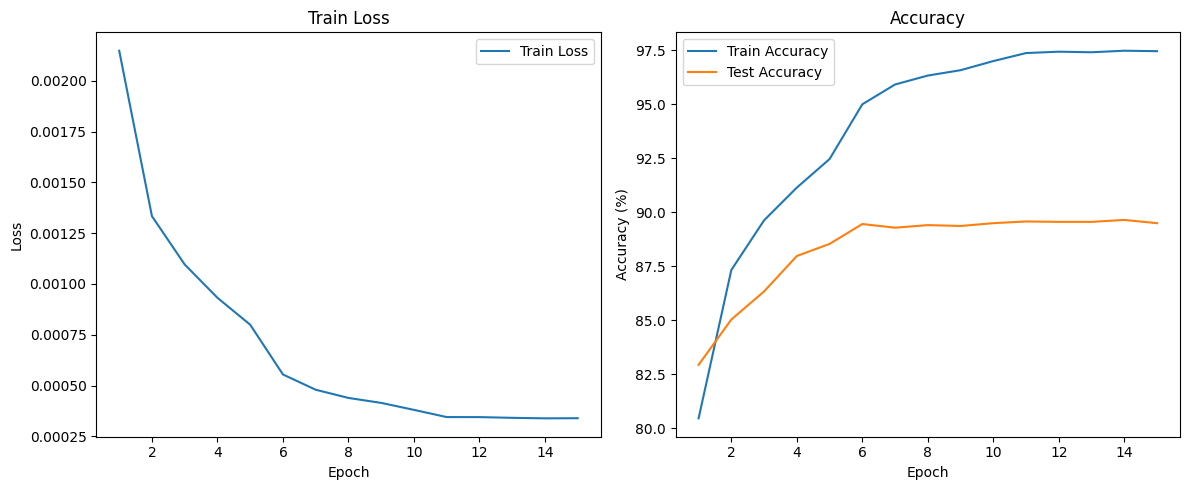

In [16]:
# Plot training history (Optional)
import matplotlib.pyplot as plt
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['test_acc'], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()